In [19]:
ls

 cc.en.300.bin                        stopwords_English1.txt
 Crawler_GBNC.ipynb                   stopwords_English2.txt
 elmo.ipynb                           Word2vec.ipynb
 fastText.ipynb                       WordCollonear.ipynb
 Glove.ipynb                          WordCollonear+.ipynb
 GoogleNews-vectors-negative300.bin   Wordnet2.ipynb
 Reptile+.ipynb                       Wordnet.ipynb
'stage one.xls'                       wordSimilarity.ipynb
'stage two.xls'


In [2]:
import pandas as pd
import xlrd #读取excel数据
import re
import nltk
from nltk.tokenize import MWETokenizer
import re
import sys, time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes

In [3]:
def stopwordslist(filepath):
    """
        从文件导入停用词表
        :param filepath: 停用词文件的地址
        :return: 停用词列表
    """
    stopwords=[line.strip() for line in open(filepath,'r',encoding='utf-8').readlines()]
    return stopwords

In [5]:
def preprocess1(doc_set,stopwords):
    """
        处理语料（数据清洗+分词+去停用词）
        :param doc_set: 语料库的数据，类型为list
        :param stopwords: 停用词列表
        :return: 处理好的文章关键词
    """
    texts = []#每篇文章关键词
    tokenizer = MWETokenizer([('german', 'measles'),('small', 'pox'),('chicken', 'pox'),('whooping', 'cough'),('epidemic', 'roseola'),
                              ('lettle', 'rose'),('measles', 'related'),('rubella', 'vaccine'),('bastard', 'measles'),('rose', 'rash'),
                              ('contagious', 'disease'),('red', 'rot'),('measles', 'containing'),('measles', 'related'),
                              ('black', 'death'),('three', 'day','measles'),('epidemic', 'measles'),('french', 'measles'),('hybrid', 'measles')
                              ,('false', 'measles'),('rubeola', 'morbillosa'),('strawberry', 'measles'),('scarlet', 'fever'),('red', 'rose')
                              ,('rash', 'of','measles'),('red', 'sandwort'),('dromal', 'rash'),('scarlatiniform', 'rash'),('copaiba', 'rashes')
                              ,('epidemic', 'influenza'),('influenza', 'scarlatina'),('malarial', 'fever')], separator = ' ') #使用MWETokenizer可以自定义词语
    for doc in doc_set:
        doc=doc.lower()
        #数据清洗
        cop=re.compile("[^a-z^A-Z^\s^ö^Ö]") #匹配非字母以外的其他字符
        cleaned_doc=cop.sub('',doc)
        # print(cleaned_doc)
        #分词
        doc_cut=tokenizer.tokenize(nltk.word_tokenize(cleaned_doc))
        # print(doc_cut)
        #去停用词
        text_list0 = [word for word in doc_cut if word not in stopwords and len(word)>3]
        texts.append(text_list0)
    return texts

In [6]:
def preprocess2(words):
    """
        将单词加入键值
        :param words: 处理好的文章关键词
        :return: 处理完的列表单词
    """
    all_words=[]
    for k in words:
        all_words.extend(k)
        all_words.append('null')
    word_to_id = {}  # 将单词转化为单词ID（健是单词，值是单词ID）
    id_to_word = {}  # 将单词ID转化为单词（健是单词ID，值是单词）
    # print(all_words)
    for word in all_words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    # 单词列表转化为单词ID列表
    corpus = np.array([word_to_id[w] for w in all_words])
    return corpus, word_to_id, id_to_word

In [7]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    """
    生成共现矩阵
    :param corpus: 语料库（单词ID列表）
    :param vocab_size: 词汇个数
    :param window_size: 窗口大小（当窗口大小为1时，左右各1个单词为上下文）
    :return: 共现矩阵
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

In [8]:
def cos_similarity(x, y, eps=1e-8):
    """
    计算余弦相似度
    :param x: 向量
    :param y: 向量
    :param eps: 用于防止“除数为0”的微小值
    :return:
    """
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)  # x的正规化
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)  # y的正规化
    return np.dot(nx, ny)  # 计算两个向量的内积

In [9]:
def most_similarity(query, word_to_id, id_to_word, word_matrix, top=5):
    """
    相似单词的查找
    :param query: 查询词
    :param word_to_id: 从单词到单词ID的字典
    :param id_to_word: 从单词ID到单词的字典
    :param word_matrix: 汇总了单词向量的矩阵，假定保存了与各行对应的单词向量
    :param top: 显示到前几位
    :return:
    """
    result_id=[] #存储结果id
    # 1. 取出查询词的单词向量
    if query not in word_to_id:
        print(f"{query} is not found")
        return
    print(f"\n[query]{query}")
    query_id = word_to_id[query]
    query_vector = word_matrix[query_id]
    # 2. 分别求得查询词的单词向量和其他所有单词向量的余弦相似度
    vocab_size = len(word_to_id)  # 词汇大小
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vector)
    # 3. 基于余弦相似度的结果，按降序显示它们的值
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        result_id.append(i)
        print(f"{id_to_word[i]}: {similarity[i]}")
        count += 1
        if count >= top:
            return result_id

In [10]:
def ppmi(C, verbose=False, eps=1e-8):
    """
    生成PPMI（正的点互信息）
    :param C: 共现矩阵
    :param verbose: 是否输出运行情况
    :param eps: 用于防止对数运算发散到负无穷大的微小值
    :return:
    """
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    print("%.1f%% done" % (100 * cnt / total))
    return M

In [11]:
class CSVD(object):
    '''
    实现svd分解降维应用示例的Python代码
    '''
    def __init__(self, data):
        self.data = data  # 用户数据
        self.S = []  # 用户数据矩阵的奇异值序列 singular values
        self.U = []  # svd后的单位正交向量
        self.VT = []  # svd后的单位正交向量
        self.k = 0  # 满足self.p的最小k值(k表示奇异值的个数)
        self.SD = []  # 对角矩阵，对角线上元素是奇异值 singular values diagonal matrix
    def _svd(self):
        '''

        用户数据矩阵的svd奇异值分解
        '''
        self.U, self.S, self.VT = np.linalg.svd(self.data)
        return self.U, self.S, self.VT
    def _calc_k(self, percentge):
        '''确定k值：前k个奇异值的平方和占比 >=percentage, 求满足此条件的最小k值
        :param percentage, 奇异值平方和的占比的阈值
        :return 满足阈值percentage的最小k值
        '''
        self.k = 0
        # 用户数据矩阵的奇异值序列的平方和
        total = sum(np.square(self.S))
        svss = 0  # 奇异值平方和 singular values square sum
        for i in range(np.shape(self.S)[0]):
            svss += np.square(self.S[i])
            if (svss / total) >= percentge:
                self.k = i + 1
                break
        return self.k
    def _buildSD(self, k):
        '''构建由奇异值组成的对角矩阵
        :param k,根据奇异值开放和的占比阈值计算出来的k值
        :return 由k个前奇异值组成的对角矩阵
        '''
        # 方法1：用数组乘方法
        self.SD = np.eye(self.k) * self.S[:self.k]
        # 方法2：用自定义方法
        e = np.eye(self.k)
        for i in range(self.k):
            e[i, i] = self.S[i]
        return self.SD
    def DimReduce(self, percentage):
        '''
        SVD降维
        :param percentage, 奇异值开方和的占比阈值
        :return 降维后的用户数据矩阵
        '''
        # Step1:svd奇异值分解
        self._svd()
        # Step2:计算k值
        self._calc_k(percentage)
        print('\n按照奇异值开方和占比阈值percentage=%.3f, 求得降维的k=%d' % (percentage, self.k))
        # Step3:构建由奇异值组成的对角矩阵singular values diagonal
        self._buildSD(self.k)
        k, U, SD, VT = self.k, self.U, self.SD, self.VT
        # Step4:按照svd分解公式对用户数据矩阵进行降维，得到降维压缩后的数据矩阵
        a = U[:len(U), :k]
        b = np.dot(SD, VT[:k, :len(VT)])
        newData = np.dot(a, b)
        return a,b,newData

In [12]:
cd drive/MyDrive/colab/

/content/drive/MyDrive/colab


In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Stage one

In [14]:
doc_set1 = []
workbook1 = xlrd.open_workbook("stage one.xls")
sheet1 = workbook1.sheet_by_name("all")
for index in range(sheet1.nrows):
    doc_set1.append(sheet1.row_values(index)[1])
stopwords1 = stopwordslist(r"stopwords_English1.txt")
texts1 = preprocess1(doc_set1,stopwords1)
corpus1, word_to_id1, id_to_word1 = preprocess2(texts1)
# for word, word_id in word_to_id1.items():
#     print(word)
C1 = create_co_matrix(corpus1, len(word_to_id1), window_size=10)
W1 = ppmi(C1)
# SVD
# svdor1 = CSVD(W1)
# U1,V1,RET1 = svdor1.DimReduce(0.681)
U1, S1, V1 = np.linalg.svd(W1)
print("U1[0]=" + str(len(U1[0])))
print("U1=" + str(len(U1)))

U1[0]=4500
U1=4500


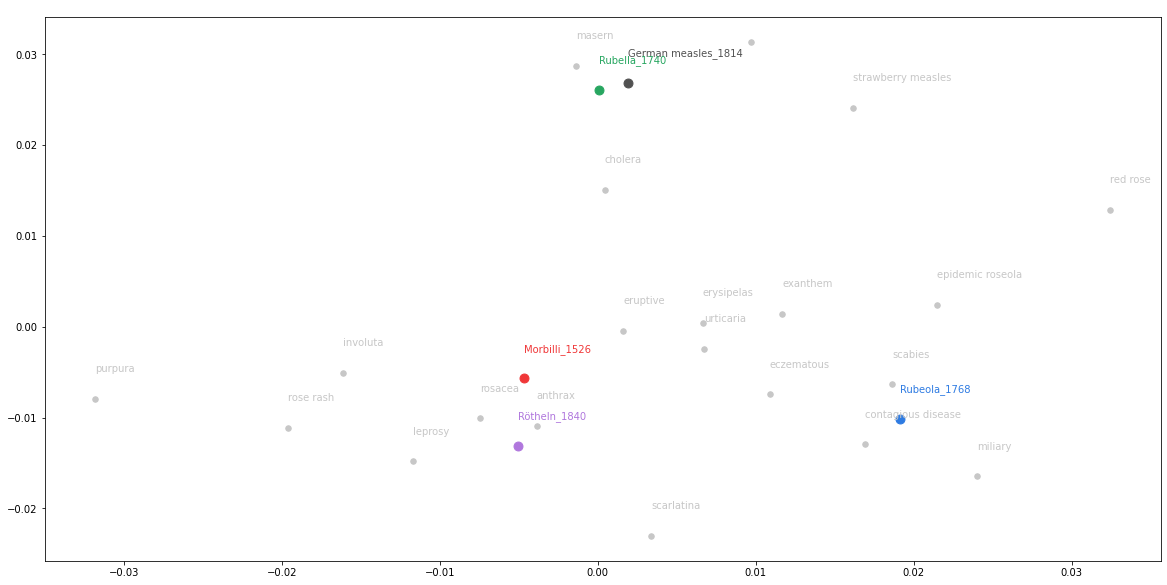

In [15]:
# PCA
pca1=PCA(n_components=2, random_state=17) # 保证每次都分割一样的训练集和测试集
reduced1=pca1.fit_transform(U1)
t1=reduced1.transpose()
# 可视化
plt.figure(figsize=(20, 10))
words1=["german measles","morbilli","rubeola","rubella","rötheln"
  ,"anthrax","cholera","miliary","leprosy","strawberry measles","epidemic roseola","erysipelas","contagious disease"
  ,"involuta","red rose","rosacea","rose rash","scarlatina","masern","eruptive","exanthem"
  ,"scabies","purpura","pustula","urticaria","eczematous"]
for word in words1:
  if word=="german measles":
    plt.annotate("German measles_1814",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.003),c='#515151')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#515151', s=80)
  elif word=="morbilli":
    plt.annotate("Morbilli_1526",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.003),c='#F03738')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#F03738', s=80)
  elif word=="rubeola":
    plt.annotate("Rubeola_1768",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.003),c='#2E7BE2')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#2E7BE2', s=80)
  elif word=="rubella":
    plt.annotate("Rubella_1740",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.003),c='#27A660')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#27A660', s=80)
  elif word=="rötheln":
    plt.annotate("Rötheln_1840",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.003),c='#B077DD')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#B077DD', s=80)
  else:
    plt.annotate(word,(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.003),c='#C7C7C7')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#C7C7C7', s=30)
plt.show()

# Stage two

In [16]:
doc_set2 = []
workbook2 = xlrd.open_workbook("stage two.xls")
sheet2 = workbook2.sheet_by_name("all")
for index in range(sheet2.nrows):
    doc_set2.append(sheet2.row_values(index)[1])
stopwords2 = stopwordslist(r"stopwords_English2.txt")
texts2 = preprocess1(doc_set2,stopwords2)
corpus2, word_to_id2, id_to_word2 = preprocess2(texts2)
# for word, word_id in word_to_id2.items():
#     print(word)
C2 = create_co_matrix(corpus2, len(word_to_id2), window_size=10)
W2 = ppmi(C2)
print("W2=" + str(len(W2[0])))
# SVD
# svdor2 = CSVD(W2)
# U2,V2,RET2 = svdor2.DimReduce(0.657)
U2, S2, V2 = np.linalg.svd(W2)
print("U2[0]=" + str(len(U2[0])))
print("U2=" + str(len(U2)))

W2=4500
U2[0]=4500
U2=4500


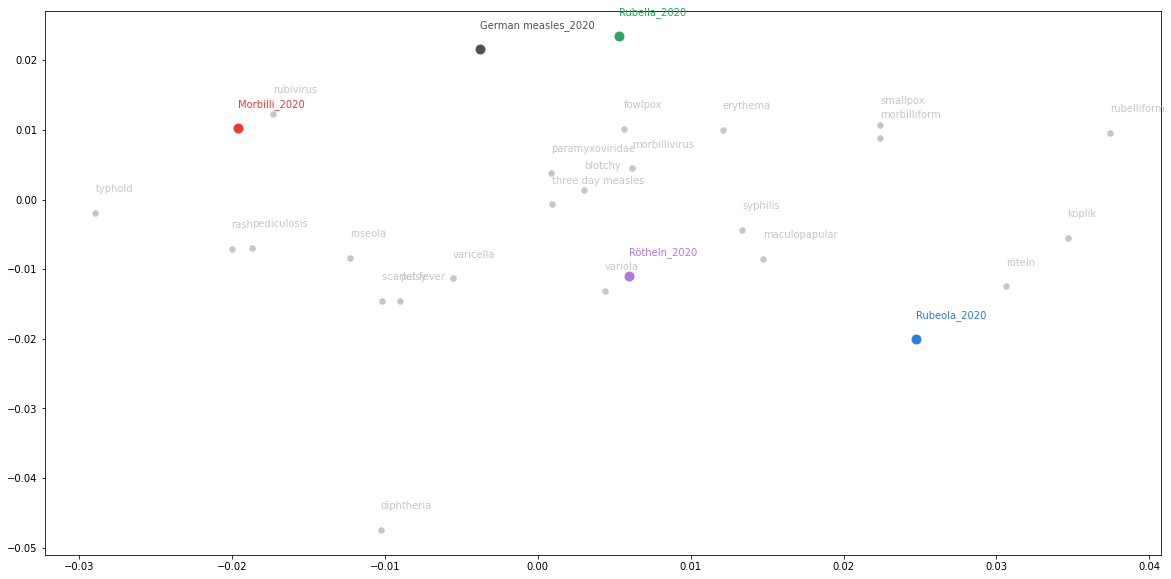

In [17]:
# PCA
pca2=PCA(n_components=2, random_state=7) # 保证每次都分割一样的训练集和测试集
reduced2=pca2.fit_transform(U2)
t2=reduced2.transpose()
# 可视化
plt.figure(figsize=(20, 10))
words2=["german measles","morbilli","rubeola","rubella","rötheln"
  ,"three day measles","palsy","blotchy","koplik","fowlpox","pediculosis","syphilis","röteln"
  ,"rubivirus","rubelliform","morbilliform","varicella","paramyxoviridae","morbillivirus","maculopapular"
  ,"diphtheria","scarlet fever","typhoid","rash","smallpox","roseola","erythema","variola"]
for word in words2:
  if word=="german measles":
    plt.annotate("German measles_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.003),c='#515151')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#515151', s=80)
  elif word=="morbilli":
    plt.annotate("Morbilli_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.003),c='#F03738')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#F03738', s=80)
  elif word=="rubeola":
    plt.annotate("Rubeola_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.003),c='#2E7BE2')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#2E7BE2', s=80)
  elif word=="rubella":
    plt.annotate("Rubella_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.003),c='#27A660')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#27A660', s=80)
  elif word=="rötheln":
    plt.annotate("Rötheln_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.003),c='#B077DD')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#B077DD', s=80)
  else:
    plt.annotate(word,(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.003),c='#C7C7C7')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#C7C7C7', s=30)
plt.show()

# Stage one + Stage two 画图

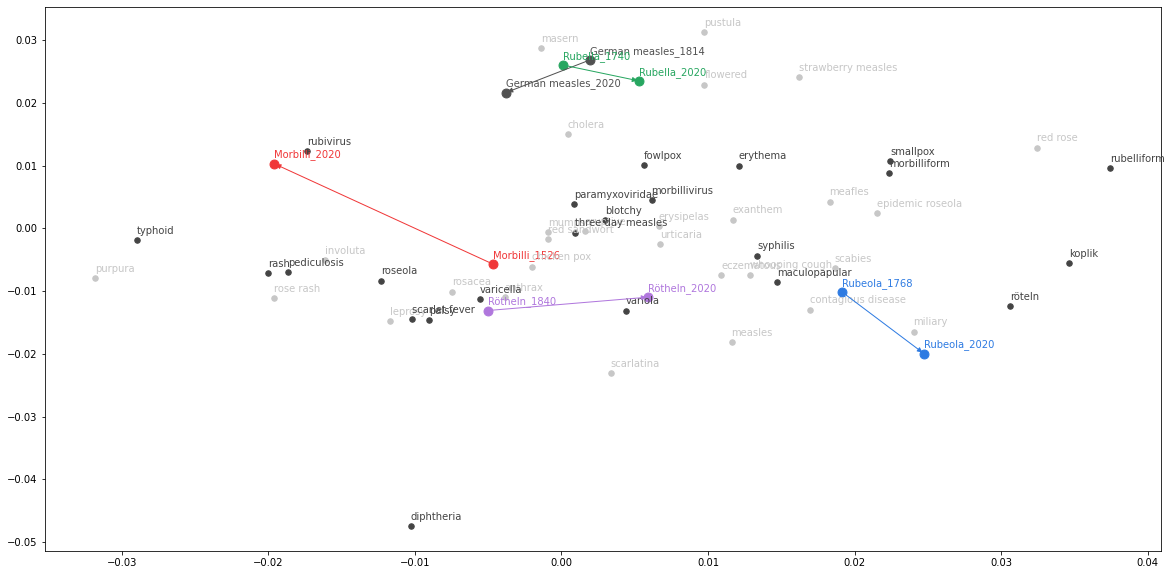

In [18]:
# PCA
pca1=PCA(n_components=2, random_state=17) # 保证每次都分割一样的训练集和测试集
reduced1=pca1.fit_transform(U1)
t1=reduced1.transpose()
# 可视化
plt.figure(figsize=(20, 10))
words1=["german measles","morbilli","rubeola","rubella","rötheln"
  ,"anthrax","cholera","miliary","leprosy","strawberry measles","epidemic roseola","erysipelas","contagious disease"
  ,"involuta","red rose","rosacea","rose rash","scarlatina","masern","eruptive","exanthem"
  ,"scabies","purpura","pustula","urticaria","eczematous"
  ,"flowered","red sandwort","chicken pox","mumps","measles","whooping cough","meafles"]
for word in words1:
  if word=="german measles":
    plt.annotate("German measles_1814",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.001),c='#515151')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#515151', s=80)
  elif word=="morbilli":
    plt.annotate("Morbilli_1526",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.001),c='#F03738')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#F03738', s=80)
  elif word=="rubeola":
    plt.annotate("Rubeola_1768",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.001),c='#2E7BE2')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#2E7BE2', s=80)
  elif word=="rubella":
    plt.annotate("Rubella_1740",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.001),c='#27A660')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#27A660', s=80)
  elif word=="rötheln":
    plt.annotate("Rötheln_1840",(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.001),c='#B077DD')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#B077DD', s=80)
  else:
    plt.annotate(word,(t1[0][word_to_id1[word]],t1[1][word_to_id1[word]]+0.001),c='#C7C7C7')
    plt.scatter(t1[0][word_to_id1[word]], t1[1][word_to_id1[word]], c='#C7C7C7', s=30)
# plt.show()
# orthogonal procrustes
# U2,sca=orthogonal_procrustes(U2,U1)
# PCA
pca2=PCA(n_components=2, random_state=7) # 保证每次都分割一样的训练集和测试集
reduced2=pca2.fit_transform(U2)
t2=reduced2.transpose()
# 可视化
words2=["german measles","morbilli","rubeola","rubella","rötheln"
  ,"three day measles","palsy","blotchy","koplik","fowlpox","pediculosis","syphilis","röteln"
  ,"rubivirus","rubelliform","morbilliform","varicella","paramyxoviridae","morbillivirus","maculopapular"
  ,"diphtheria","scarlet fever","typhoid","rash","smallpox","roseola","erythema","variola"
  ]
for word in words2:
  if word=="german measles":
    plt.annotate("German measles_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.001),c='#515151')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#515151', s=80)
  elif word=="morbilli":
    plt.annotate("Morbilli_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.001),c='#F03738')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#F03738', s=80)
  elif word=="rubeola":
    plt.annotate("Rubeola_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.001),c='#2E7BE2')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#2E7BE2', s=80)
  elif word=="rubella":
    plt.annotate("Rubella_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.001),c='#27A660')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#27A660', s=80)
  elif word=="rötheln":
    plt.annotate("Rötheln_2020",(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.001),c='#B077DD')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#B077DD', s=80)
  else:
    plt.annotate(word,(t2[0][word_to_id2[word]],t2[1][word_to_id2[word]]+0.001),c='#444444')
    plt.scatter(t2[0][word_to_id2[word]], t2[1][word_to_id2[word]], c='#444444', s=30)
# 连线
words=["german measles","morbilli","rubeola","rubella","rötheln"]
word_colors=["#515151","#F03738","#2E7BE2","#27A660","#B077DD"]
for i in range(5):
  plt.annotate("",xy=(t2[0][word_to_id2[words[i]]],t2[1][word_to_id2[words[i]]])
          ,xytext=(t1[0][word_to_id1[words[i]]],t1[1][word_to_id1[words[i]]])
          ,arrowprops=dict(arrowstyle="-|>",connectionstyle="arc3",color=word_colors[i]))
plt.show()

In [ ]:
most_similarity("german measles", word_to_id1, id_to_word1, C1, top=100)


[query]german measles
diphtheria: 0.979628735722041
chicken pox: 0.9751843683491803
mumps: 0.9730896544396692
whooping cough: 0.9726493107221588
chickenpox: 0.9635117442558412
scarlet fever: 0.9593359103206369
measles: 0.9493768130818432
fever: 0.9484895190334919
smallpox: 0.9470440804932408
scarlet: 0.9321199236923945
dysentery: 0.9307830043115296
tuberculosis: 0.9298252223282089
diphtuberculosis: 0.9272394240614509
cerebrospinal: 0.9262574977082638
erysipelas: 0.9123631101914528
disturbance: 0.9085467076082903
trachoma: 0.9059409996090594
typhoid: 0.9049455378468467
permitted: 0.9028722081472215
varicella: 0.8988841143678149
elastic: 0.8975929216688396
confusacteristics: 0.895492899260736
pathognomonic: 0.8921333175215753
pustules: 0.891351287862654
shown: 0.8910855244903944
poliomyelitis: 0.8902528987118268
conflufrom: 0.8892095885769975
templars: 0.8884115366748322
tubingen: 0.8855001516601553
pustular: 0.8846291637323787
syphilide: 0.8846291637323785
grippe: 0.8845423485668233
br

[24,
 47,
 13,
 44,
 12,
 16,
 2,
 9,
 7,
 50,
 117,
 65,
 105,
 23,
 14,
 57,
 63,
 64,
 56,
 66,
 454,
 33,
 76,
 59,
 336,
 55,
 60,
 88,
 107,
 45,
 46,
 217,
 75,
 79,
 106,
 58,
 6,
 477,
 81,
 19,
 1,
 15,
 17,
 27,
 104,
 87,
 216,
 61,
 54,
 74,
 455,
 18,
 279,
 222,
 40,
 32,
 11,
 77,
 21,
 238,
 458,
 468,
 86,
 49,
 99,
 102,
 25,
 456,
 5,
 26,
 306,
 262,
 444,
 443,
 445,
 73,
 90,
 22,
 92,
 3,
 43,
 68,
 207,
 48,
 397,
 62,
 170,
 401,
 400,
 8,
 72,
 110,
 403,
 52,
 96,
 457,
 109,
 209,
 402,
 80]

In [ ]:
most_similarity("rötheln", word_to_id1, id_to_word1, C1, top=100)

In [ ]:
most_similarity("morbilli", word_to_id1, id_to_word1, C1, top=100)

In [ ]:
most_similarity("rubeola", word_to_id1, id_to_word1, C1, top=100)

In [ ]:
most_similarity("rubella", word_to_id1, id_to_word1, C1, top=100)

In [ ]:
most_similarity("german measles", word_to_id2, id_to_word2, C2, top=100)

In [ ]:
most_similarity("rubella", word_to_id2, id_to_word2, C2, top=100)

In [ ]:
most_similarity("rötheln", word_to_id2, id_to_word2, C2, top=100)

In [ ]:
most_similarity("morbilli", word_to_id2, id_to_word2, C2, top=100)

In [ ]:
most_similarity("rubeola", word_to_id2, id_to_word2, C2, top=100)

In [ ]:
# Stage one
vector1 = C1[word_to_id1["varicella zoster"]]
vector2 = C1[word_to_id1["rötheln"]]
sim1 = cos_similarity(vector1,vector2)
print(sim1)

In [ ]:
# Stage two
vector3 = C2[word_to_id2["roseola"]]
vector4 = C2[word_to_id2["rötheln"]]
sim2 = cos_similarity(vector3,vector4)
print(sim2)

0.6611734773212178
